In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import json
import cv2

# 모델 및 데이터셋 클래스 임포트
from models import Net
from custom_transforms import Rescale, Normalize, ToTensor
from facial_keypoints_dataset import CatKeypointsDataset

%load_ext autoreload
%autoreload 2


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
# 데이터 경로 설정
labels_dir = '/home/work/XAI/BITAmin/CatFLW/labels'
images_dir = '/home/work/XAI/BITAmin/CatFLW/images'

# 데이터 변환 정의
data_transform = transforms.Compose([
    Rescale((224, 224)),  # 크기를 224x224로 조정
    Normalize(color=True),  # RGB로 유지
    ToTensor()
])

In [6]:
# 데이터셋 및 데이터로더 생성
train_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)
test_dataset = CatKeypointsDataset(labels_dir=labels_dir, images_dir=images_dir, transform=data_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [7]:
# 모델 인스턴스화 및 출력
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [8]:
# 네트워크 샘플 출력 함수
def net_sample_output(model, test_loader):
    for i, sample in enumerate(test_loader):
        images = sample["image"].to(device)
        key_pts = sample["keypoints"].to(device)

        images = images.type(torch.FloatTensor).to(device)
        output_pts = model(images)
        output_pts = output_pts.view(output_pts.size()[0], 48, 2)  # [batch_size, 48, 2]

        if i == 0:
            return images, output_pts, key_pts

# 함수 호출 및 출력 크기 확인
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.size())  # Should be [batch_size, 3, 224, 224]
print(test_outputs.size())  # Should be [batch_size, 48, 2]
print(gt_pts.size())  # Should be [batch_size, 48, 2]

torch.Size([64, 3, 224, 224])
torch.Size([64, 48, 2])
torch.Size([64, 48, 2])


In [9]:
# 키포인트 시각화 함수
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    plt.imshow(image, cmap="gray")
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker=".", c="m")
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker=".", c="g")

In [10]:
# 시각화 함수
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)
        image = test_images[i].cpu().data.numpy()
        image = np.transpose(image, (1, 2, 0))
        predicted_key_pts = test_outputs[i].cpu().data.numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().data.numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis("off")
    plt.show()


In [11]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
# 훈련 함수 정의
def train_net(n_epochs):
    losses = []
    net.train()
    for epoch in tqdm_notebook(range(n_epochs), desc="training"):
        running_loss = 0.0
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):
            images = data["image"].to(device)
            key_pts = data["keypoints"].to(device)
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Avg. Loss: {running_loss / len(train_loader)}")
    return losses
    print("Finished Training")


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

training:   0%|          | 0/14 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 1, Avg. Loss: 0.7052722880334565


epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 2, Avg. Loss: 0.45194925593607355


epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 3, Avg. Loss: 0.3663708811456507


epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 4, Avg. Loss: 0.3139564936811274


epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 5, Avg. Loss: 0.28847610769849835


epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 6, Avg. Loss: 0.24433804461450287


epoch 6:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 7, Avg. Loss: 0.21538331698287616


epoch 7:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 8, Avg. Loss: 0.18742180728551114


epoch 8:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 9, Avg. Loss: 0.17394414860190768


epoch 9:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 10, Avg. Loss: 0.16554669426246124


epoch 10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 11, Avg. Loss: 0.15532362099849817


epoch 11:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 12, Avg. Loss: 0.1441684254642689


epoch 12:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 13, Avg. Loss: 0.13456876214706537


epoch 13:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 14, Avg. Loss: 0.12651609629392624


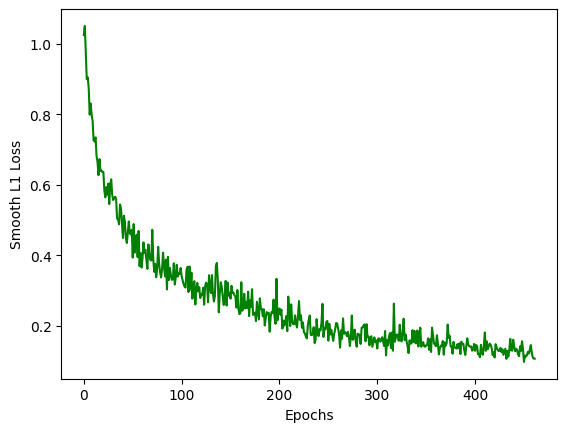

In [13]:
# 네트워크 훈련
n_epochs = 14
losses = train_net(n_epochs)
plt.xlabel("Epochs")
plt.ylabel("Smooth L1 Loss")
plt.plot(losses, "g-")

torch.Size([64, 3, 224, 224])
torch.Size([64, 48, 2])
torch.Size([64, 48, 2])


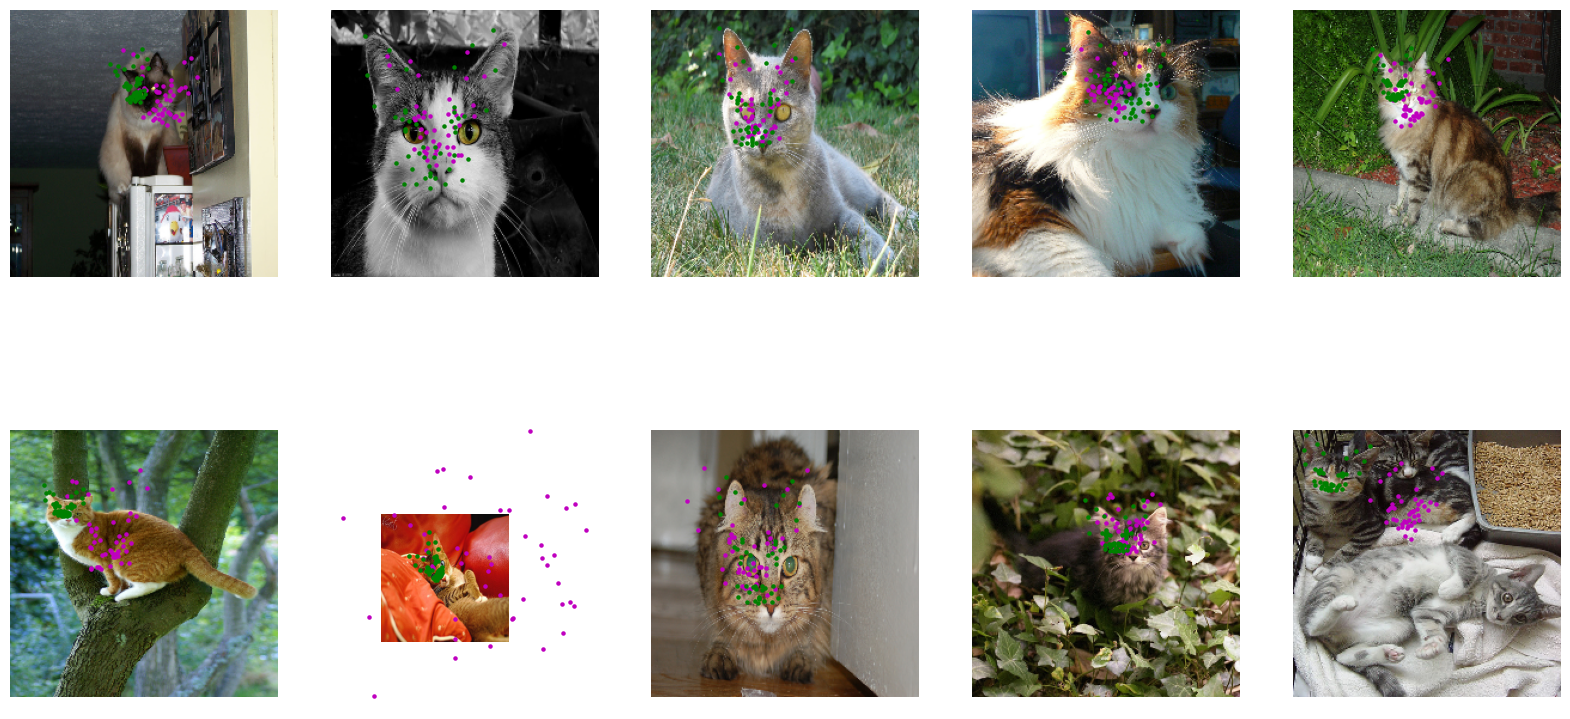

In [14]:
# 모델 저장
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_name = "cat_keypoints_model.pt"
model_path = os.path.join(model_dir, model_name)
torch.save(net.state_dict(), model_path)

# 테스트 데이터 다시 가져오기
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)
print(test_images.size())
print(test_outputs.size())
print(gt_pts.size())

# 테스트 출력 시각화
visualize_output(test_images, test_outputs, gt_pts)

[[ 0.01576489 -0.00819442  0.05427377 -0.01294058]
 [ 0.03075521  0.03953458  0.15438019  0.11189535]
 [-0.02783965  0.07136357 -0.00699604 -0.02126938]
 [ 0.00359108 -0.08369096  0.01381187 -0.00918878]]
(4, 4)


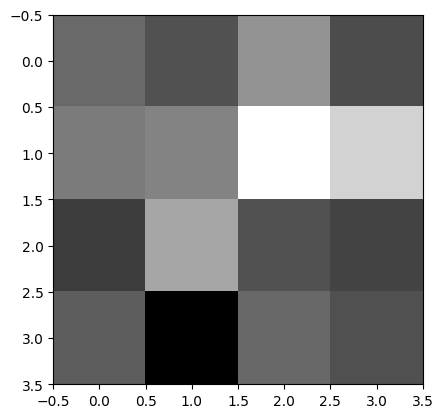

In [15]:
# 첫 번째 conv 레이어의 필터 가중치 시각화
weights1 = net.conv1.weight.data.cpu()
w = weights1.numpy()
filter_index = 0
print(w[filter_index][0])
print(w[filter_index][0].shape)
plt.imshow(w[filter_index][0], cmap="gray")

First convolutional layer


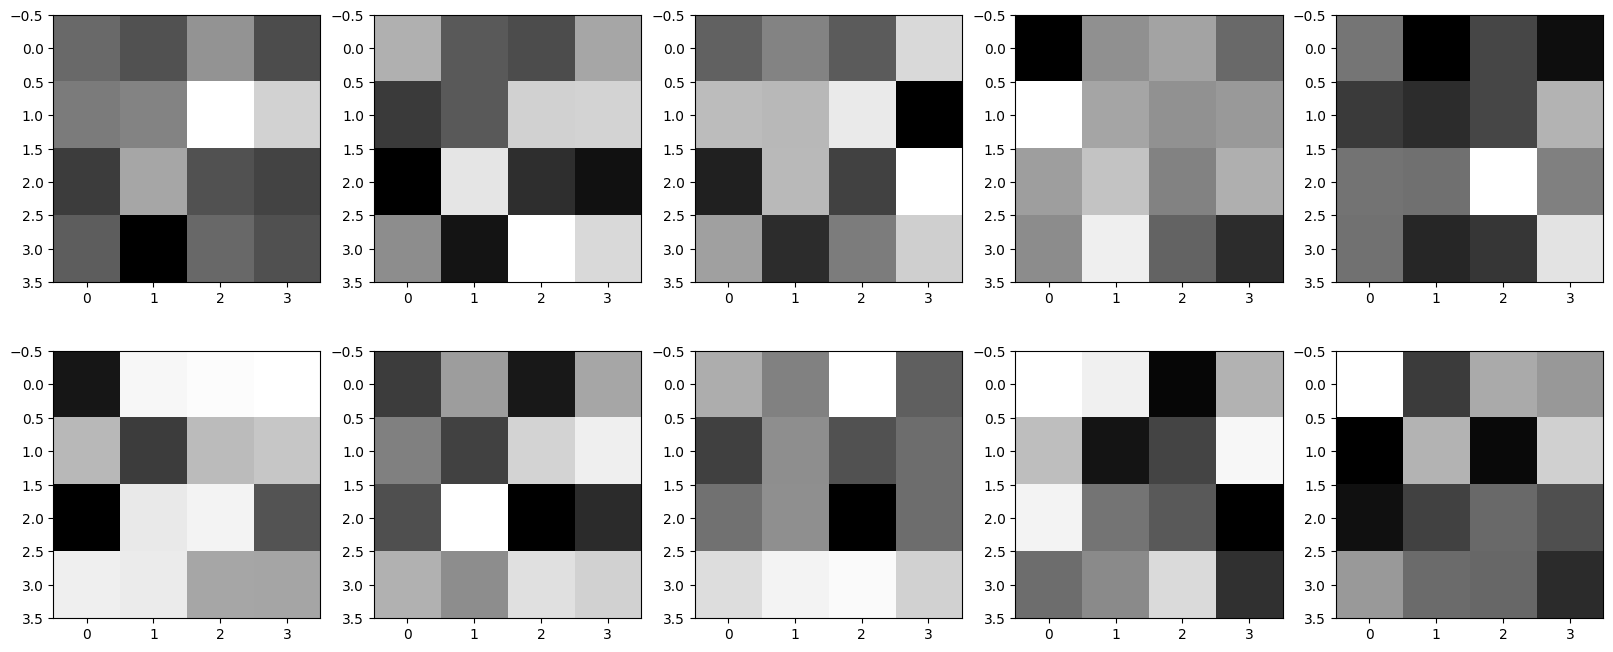

In [16]:
# 첫 번째 conv 레이어의 필터 시각화
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(w[i][0], cmap="gray")
print("First convolutional layer")
plt.show()


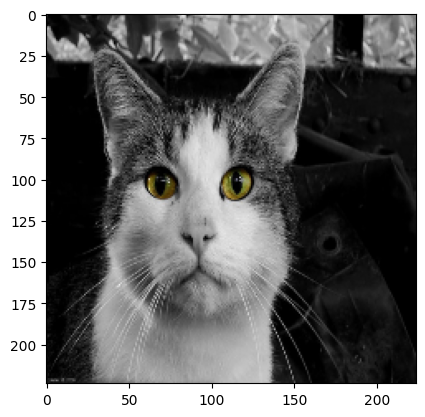

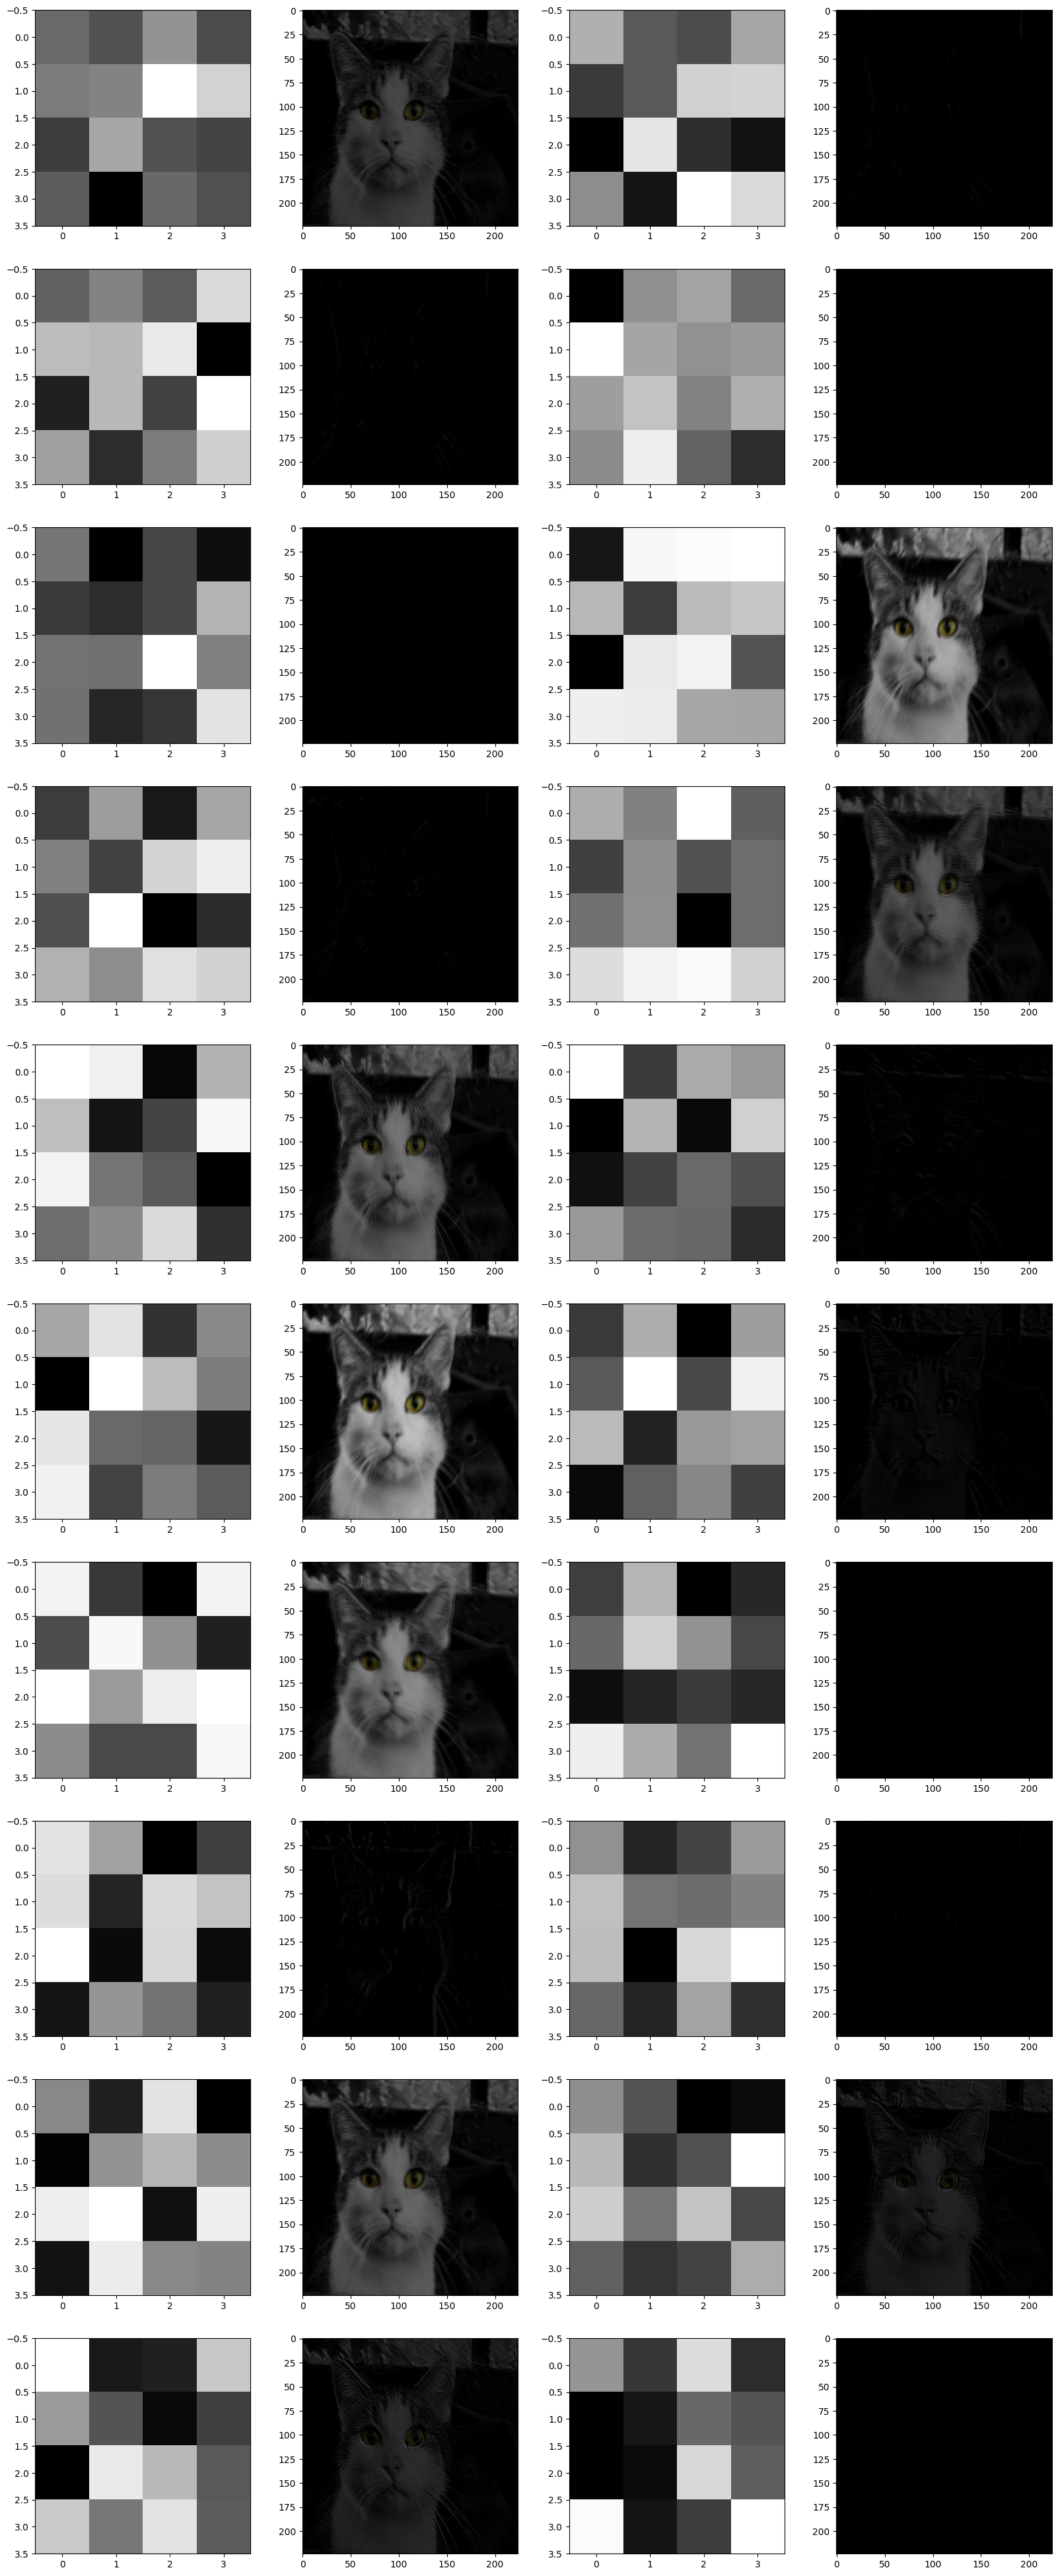

In [19]:
# 필터가 적용된 이미지 시각화
img = np.transpose(test_images[1].cpu().numpy(), (1, 2, 0))  # 형식을 (높이, 너비, 채널)로 변경
plt.imshow(img)
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i % 2) == 0:
        plt.imshow(w[int(i / 2)][0], cmap="gray")
    else:
        c = cv2.filter2D(img, -1, w[int((i - 1) / 2)][0])
        plt.imshow(c, cmap="gray")
plt.show()
